# Imports and initializations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
# add our custom modules to the python import path
import sys
import os
sys.path.append(os.getcwd() + '/../Client_modules/')

import mResSweepDouble
from socProxy import makeProxy
import h5py
from PythonDrivers.control_atten import setatten
# import PythonDrivers.YOKOGS200 as YOKOGS200
import matplotlib.pyplot as plt
savePath = r'Z:\t1Team\Data\2024-04-01_BFE_cooldown\TAHP02_Nb-Ta_C1'
import numpy as np

# Python 3.7
# os.environ['PATH'] = os.getcwd() + '\\PythonDrivers' + os.pathsep + os.environ['PATH']
# Python 3.8 and newer
os.add_dll_directory(os.getcwd() + '/../Client_modules/PythonDrivers')

from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

In [4]:
# create proxy to ZCU216 board
soc, soccfg = makeProxy('192.168.0.192')
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_d08fdb6936fc4d42a7ecc4620f622597@192.168.0.192:34213

QICK configuration:

	Board: ZCU216

	Software version: 0.2.208
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS,

## Define sweep parameters

In [121]:
inputDict = {}
inputDict['LO_f'] = 0  # local oscillator frequency

# define frequencies
inputDict['span_f'] = [5000, 0]
#inputDict['span_f'] = [10.0, 10.0]

# center freqs
inputDict['res_f']=[6000.0, 0.0]
inputDict['names']=['test1','test2']

# define numbers of points
inputDict['n_expts'] = 2*5*1000  # number of points along the frequency axis
inputDict['n_rounds'] = 1  # number of times to sweep along the frequency axis
inputDict['n_reps'] = 1  # number of repetitions to take at each frequency point

inputDict['save_path'] = savePath

# timing. Units are clock cycles, but converted from us
inputDict['ring_up_time'] = 500  # time waiting for the resonator to ring up at the start of each sweep
inputDict['ring_between_time'] = 50  # time waiting for the resonator to ring up at the start of each sweep
inputDict['readout_length'] = 10000  # time to average over
inputDict['adc_trig_offset'] = 0.1  # time after the DAC starts the final steady pulse before the ADC starts it's read

# power
inputDict['base_powers'] = [0,0] # dBm
inputDict['gain'] = [30000, 30000]


## Acquire data

In [122]:
#from PythonDrivers.ldausbcli import CLI_Vaunix_Attn

In [123]:
#attobj = CLI_Vaunix_Attn()

# attobj.get_channels_number(1)
# attobj.get_serial_number(1)
# attobj.set_attenuation(1,0,1)

#attobj.set_attenuation(1,0,2)

# attobj.set_attenuation(1,0,3)
# attobj.set_attenuation(1,0,4)

In [124]:
# Acquire
inputDict['powers'] = inputDict['base_powers'] #rewrite this line for power sweeps to take in calibrated power and subtract atten
Instance = mResSweepDouble.ResSweep(path=savePath, prefix='data', inputDict=inputDict, soc=soc, soccfg=soccfg)
# 12.9 dBm at 6 GHz
with open(devnull,'w') as f:
    with redirect_stderr(f):
        data = mResSweepDouble.ResSweep.acquire(Instance)

# mResSweep.ResSweep.save_data(Instance, data)

Frequencies out are: [6000.0, 0.0] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\deleo\Documents\GitHub\HouckLab_QICK\WorkingProjects\QM_Team\resonator_measurements\template_notebooks/../Client_modules\mResSweepDouble.py:305: UserWarning: Temperature log is 37367.5 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 253.981 s


# display results

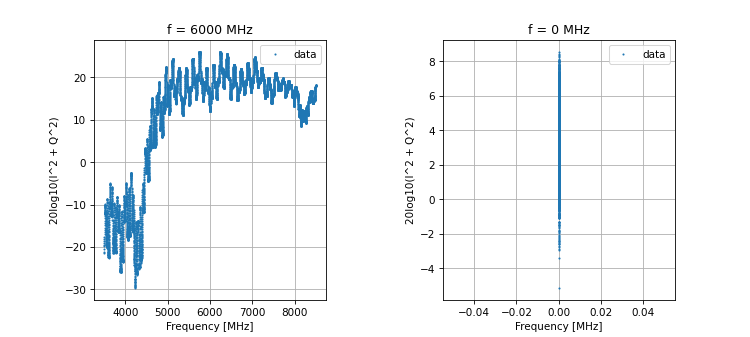

([[], []], [[], []])

In [126]:
mResSweepDouble.ResSweep.display(Instance, data, fit=False)
# print(Instance.data['data']['power'])

# Convert ADC units to dBm

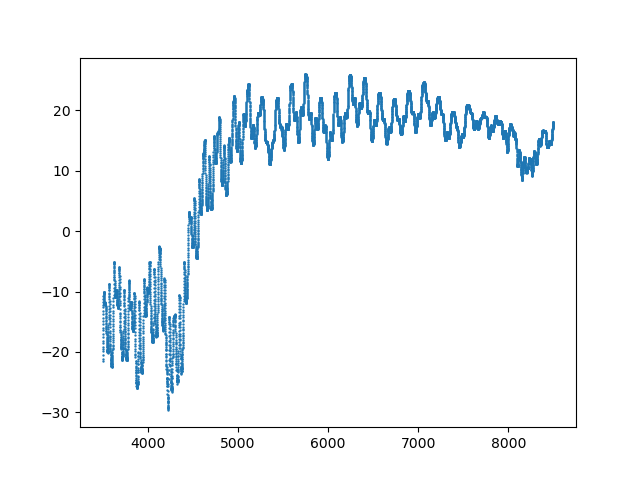

In [127]:
fig,ax = plt.subplots()
amp_log=data['data']['ampArray_log']
ax.scatter(Instance.resArray_f[0],amp_log[0],marker='.',s=2)

In [128]:
#def ADCtodBm(amp_log,rfsoc_id):
    #if rfsoc_id==10:
    #    return amp_log + (-13.1-47.5)
    #if rfsoc_id==11:
    #    return amp_log + (-13.2-47.0)
    #if rfsoc_id==12:
    #    return amp_log + (-13-52.25)
    #if rfsoc_id==13:
    #    return amp_log + (-18.3-39.75)

amp_log[0] = amp_log[0] + (-12.672 + 12.9)
#amp_log[1] = amp_log[1] + (-12.225 + 12.9)

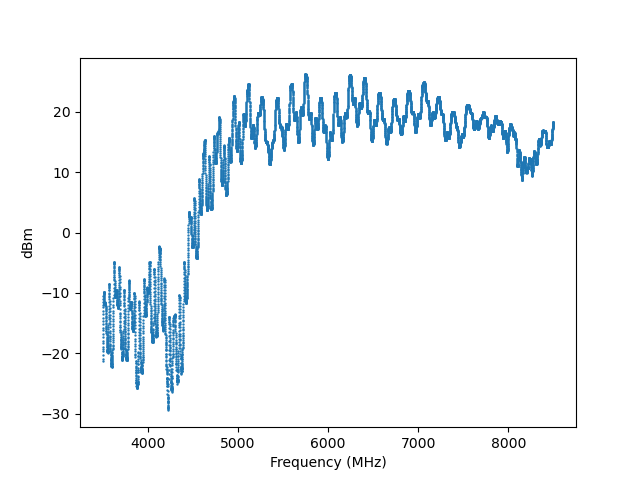

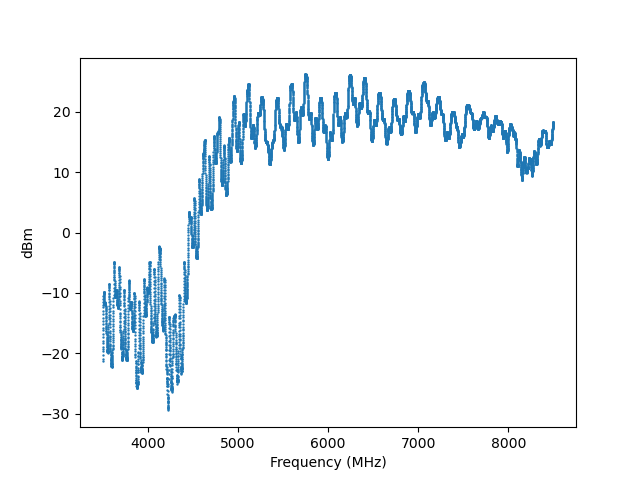

In [129]:
fig,ax = plt.subplots()
#amp_log=data['data']['ampArray_log']
#dBm=ADCtodBm(amp_log[0],11)
ax.scatter(Instance.resArray_f[0],amp_log[0],marker='.',s=2)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBm')
fig.show()

In [130]:
np.savez(r'Z:\t1Team\Data\2024-04-01_BFE_cooldown\RFSoC_calibration_dBm_lookup_splitter_RTamp_filter_splitter',f=Instance.resArray_f[0],dBm=amp_log[0])